In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


In [93]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [94]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load[2000:]]
valset = [texttoint[c] for c in load[:2000]]

sequence_length = 1
vocab_size = len(texttoint)
inputs = torch.tensor(dataset[:-1])
labels = torch.tensor(dataset[1:])
val_inputs = torch.tensor(valset[:-1])
val_labels = torch.tensor(valset[1:])

# Optimizer

The architecture looks right but the loss is not going down as well as expected, let's try changing simple gradient descent to a more elaborate optimizer <br>
We won't bother coding this up by ourselves because it's already implemented in pytorch and really easy to use from there <br>
If you want, you can change from torch.optim.Adam to torch.optim.SGD and look how fast Adam really is

In [95]:
hidden_size = 128

w1 = torch.randn(vocab_size, hidden_size, requires_grad=True)
b1 = torch.randn(hidden_size, requires_grad=True)
w2 = torch.randn(hidden_size, vocab_size, requires_grad=True)
b2 = torch.randn(vocab_size, requires_grad=True)

params = [w1, b1, w2, b2]
with torch.no_grad():
    for p in params:
        p /= p.shape[0] ** 0.5

epochs = 2000
batch_size = 1024
optimizer = torch.optim.Adam(params, lr=1e-3)
lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float()
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        X = F.one_hot(val_inputs.long(), vocab_size).float()
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

Epoch ___0 - Loss: 4.223


KeyboardInterrupt: 

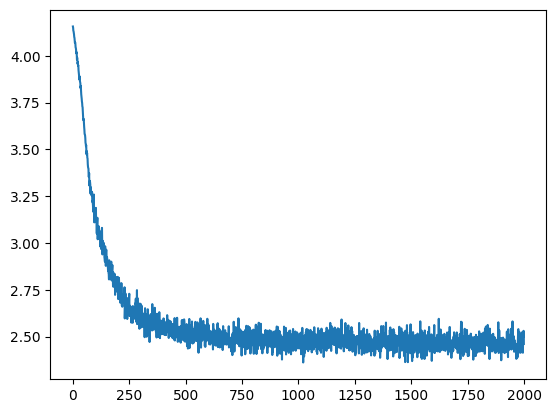

In [ ]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

As you can see adam maxes out the model really fast (around 250 epochs instead of 10000+), let's take a look at what it can write

In [ ]:
string = "The meaning of life is: \n"

with torch.no_grad():
    for _ in range(100):
        X = F.one_hot(torch.tensor(texttoint[string[-1]]), vocab_size).float()
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        string += inttotext[torch.multinomial(F.softmax(pred, dim=0), 1).item()]
        print(string[-1], end="")


WA:
CETOrasodee hesles shoun. tishooathankies tod! my, cerd dicar;
K:
cowsl orou gshimid chileanstha

# Longer sequences
The outputs seem better than random, but we should aim at a loss way lower than 2.5... First thing that comes to mind is that we should give the model more context, because now we are just passing the last character

In [ ]:
sequence_length = 3

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[:, :-1][2000:]
labels = sequences[:, -1][2000:]
val_inputs = sequences[:, :-1][:2000]  
val_labels = sequences[:, -1][:2000]

In [ ]:
hidden_size = 128

w1 = torch.randn(vocab_size*sequence_length, hidden_size, requires_grad=True)  # notice the vocab_size*sequence_length
b1 = torch.randn(hidden_size, requires_grad=True)
w2 = torch.randn(hidden_size, vocab_size, requires_grad=True)
b2 = torch.randn(vocab_size, requires_grad=True)

params = [w1, b1, w2, b2]
with torch.no_grad():
    for p in params:
        p /= torch.norm(p, dim=0)

epochs = 2000
batch_size = 1024
optimizer = torch.optim.Adam(params, lr=1e-3)
lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float() # this has shape (batch_size, sequence_length, vocab_size), but we want (batch_size, vocab_size*sequence_length)
    X = X.reshape(batch_size, -1) # -1 means "infer the size from the other dimensions"
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        X = F.one_hot(val_inputs.long(), vocab_size).float()
        X = X.reshape(len(val_inputs), -1)
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

Epoch ___0 - Loss: 4.118
Epoch _200 - Loss: 2.592
Epoch _400 - Loss: 2.224
Epoch _600 - Loss: 2.112
Epoch _800 - Loss: 2.212
Epoch 1000 - Loss: 2.084
Epoch 1200 - Loss: 2.041
Epoch 1400 - Loss: 2.000
Epoch 1600 - Loss: 1.950
Epoch 1800 - Loss: 1.959


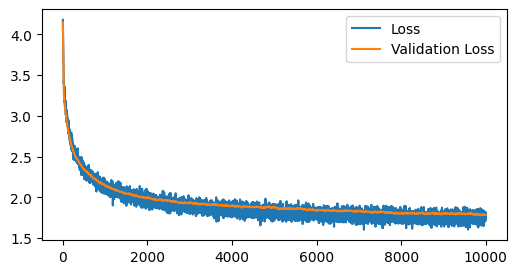

In [ ]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In [ ]:
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[:, :-1][2000:]
labels = sequences[:, -1][2000:]
val_inputs = sequences[:, :-1][:2000]
val_labels = sequences[:, -1][:2000]

We are getting a way better loss, around 1.9 instead of 2.5 <br> 
Now let's try a wider input sequence, 20 should allow us to cover 3-5 words

In [ ]:
hidden_size = 128

w1 = torch.randn(vocab_size*sequence_length, hidden_size, requires_grad=True)
b1 = torch.randn(hidden_size, requires_grad=True)
w2 = torch.randn(hidden_size, vocab_size, requires_grad=True)
b2 = torch.randn(vocab_size, requires_grad=True)

params = [w1, b1, w2, b2]
with torch.no_grad():
    for p in params:
        p /= torch.norm(p, dim=0)

epochs = 2000
batch_size = 1024
optimizer = torch.optim.Adam(params, lr=1e-3)
lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float() # this has shape (batch_size, sequence_length, vocab_size), but we want (batch_size, vocab_size*sequence_length)
    X = X.reshape(batch_size, -1) # -1 means "infer the size from the other dimensions"
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        X = F.one_hot(val_inputs.long(), vocab_size).float().view(len(val_inputs), -1)
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

Epoch ___0 - Loss: 4.226
Epoch _200 - Loss: 2.510
Epoch _400 - Loss: 2.149
Epoch _600 - Loss: 2.090
Epoch _800 - Loss: 2.074
Epoch 1000 - Loss: 2.083
Epoch 1200 - Loss: 2.027
Epoch 1400 - Loss: 2.054
Epoch 1600 - Loss: 1.953
Epoch 1800 - Loss: 1.833


Running this model took way too much (around 3 times longer than before), and it seems harder to optimize let's explore why... 

In [ ]:
for param, name in zip([w1, b1, w2, b2], ["w1", "b1", "w2", "b2"]):
    # print variable name, shape and number of parameters
    print(name, param.shape, param.numel())   

w1 torch.Size([1300, 128]) 166400
b1 torch.Size([128]) 128
w2 torch.Size([128, 65]) 8320
b2 torch.Size([65]) 65


The first layer has WAAAY too many parameters, it scales with sequence_length * vocab_size * hidden_size <br>
How can we improve on this? <br>
- Lowering sequence_length decreases performance
- vocab_size seems oddly inefficient with one_hot embeddings [0, 0, 0, 0, 1, 0, 0, 0]
- Lowering hidden_size decreases performance 

Let's think about vocab_size, right now with one_hot embeddings we are using 65 parameters to store a small int <br> 
We can't pass the int by itself, because neural networks are not good at picking up small differences in int values like that. <br><br>
One idea would be to reduce the dimensionality to something more managable, like 5 parameters, but how? <br>
We could simply make a list initialized at random of 5 parameter embeddigs for each value in the vocabulary... We call these embeddings <br>

Embeddings not only allow us to be more parameter efficient than one_hot encoding, they have O(n) complexity and allow us to map each integer value in the input space to a trained vector space where each embedding trends towards a good representation for the meaning of the inputs. 

In [ ]:
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[:, :-1][2000:]
labels = sequences[:, -1][2000:]
val_inputs = sequences[:, :-1][:2000]
val_labels = sequences[:, -1][:2000]

In [ ]:
emb_size = 10  # I chose 10 parameter embeddings, but you can try different values
hidden_size = 128

embeddings = torch.randn(vocab_size, emb_size)  # Assigning a random vector to each character in the vocabulary (this will be trained)
w1 = torch.randn(emb_size*sequence_length, hidden_size, requires_grad=True)
b1 = torch.randn(hidden_size, requires_grad=True)
w2 = torch.randn(hidden_size, vocab_size, requires_grad=True)
b2 = torch.randn(vocab_size, requires_grad=True)

with torch.no_grad():
    for p in [w1, b1, w2, b2]:
        p /= torch.norm(p, dim=0)

epochs = 2000
batch_size = 1024
optimizer = torch.optim.Adam([embeddings, w1, b1, w2, b2], lr=1e-3)  # dont forget to add embeddings to the optimizer
lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    emb = embeddings[inputs[indexes]].view(batch_size, -1)
    h1 = F.gelu(emb @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        emb = embeddings[val_inputs].reshape(len(val_inputs), -1)
        h1 = F.gelu(emb @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

Epoch ___0 - Loss: 4.454
Epoch _200 - Loss: 2.816
Epoch _400 - Loss: 2.598
Epoch _600 - Loss: 2.444
Epoch _800 - Loss: 2.308
Epoch 1000 - Loss: 2.251
Epoch 1200 - Loss: 2.229
Epoch 1400 - Loss: 2.176
Epoch 1600 - Loss: 2.104
Epoch 1800 - Loss: 2.202


As you can see the model runs well, but now the complexity of the code is getting problematic, luckily pytorch has most of this already implemented. 
Just like we did before with the loss and the optimizer, here we can substitute the layers with pre made ones. 

In [ ]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.w1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.w2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        h1 = F.gelu(self.w1(emb))
        return self.w2(h1)
    
model = Model(emb_size=10, hidden_size=128)

In [ ]:
epochs = 2000
batch_size = 1024
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes]) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs)
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

Epoch ___0 - Loss: 4.200
Epoch _200 - Loss: 2.577
Epoch _400 - Loss: 2.449
Epoch _600 - Loss: 2.237
Epoch _800 - Loss: 2.273
Epoch 1000 - Loss: 2.209
Epoch 1200 - Loss: 2.050
Epoch 1400 - Loss: 2.063
Epoch 1600 - Loss: 2.018
Epoch 1800 - Loss: 1.977


As you can see the torch version works just as well, if not better, they have smarter initializations than ours and it's all around more refined

Now we will move the training to the GPU to make it even faster

In [ ]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        h1 = F.gelu(self.fc1(emb))
        return self.fc2(h1)


device = torch.device("cuda:0")  # Set the device to GPU (cuda) 
model = Model(emb_size=10, hidden_size=128).to(device)  # Send the model to GPU

In [ ]:
epochs = 10000
batch_size = 1024
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device))  # Send the inputs to GPU
    loss = F.cross_entropy(pred, labels[indexes].to(device))  # Send the labels to GPU

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

Epoch ___0 - Loss: 4.179
Epoch 1000 - Loss: 2.209
Epoch 2000 - Loss: 1.987
Epoch 3000 - Loss: 1.902
Epoch 4000 - Loss: 1.834
Epoch 5000 - Loss: 1.784
Epoch 6000 - Loss: 1.742
Epoch 7000 - Loss: 1.780
Epoch 8000 - Loss: 1.779
Epoch 9000 - Loss: 1.691


The performance of the model is the same but everything happens in about a third of the time on my pc (ryzen 3100 and 3060 12GB) <br>
Note: GPUs are often bandwith bound, not compute bound, so higher batch sizes play well with text, for example it may be that from 1 to 512 the training time stays basically the same, because the gpu is able to compute all of these in parallel and under a certain batch size you will not be taking advantage of this. <br>
Now let's train it for a while and take a look at some predictions

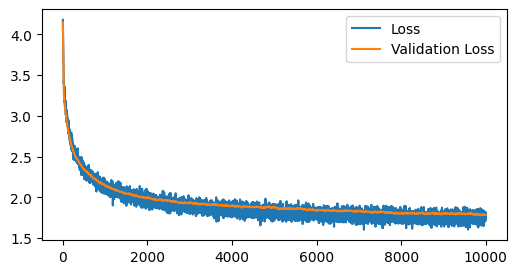

In [ ]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In [ ]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(1000):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        #print(X)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


             
KING RICHARD IIIS:
Sy lothial, I whosed froy!

CORIOLANUS:
Enforely cresm prased, you there.

Secold bust me las what Bapains youl the shall darcess'd to rech limting ple.

TRANIO:
So keld need; make wereconsed acce abime singry thilds,
And therex Vimer!
Thouse of hea? by such a-bone;
But not trom yoult all my sentlemann ope,
Derengeans cray ness, I'lish, my with Covung, to guse have Mother?

AUCIO:
Nays my frompe to-lusse, mady thee gendinghants my bud bardin with wit broing hald again
Maugain ry gonnot kay' queed.

MISTB OFI
Than sey, you ligatiem, harge dy ped all.

QUEEN ELTZANganis, hat's be purgapss, and we pare,
How I more hath mathe, if, come asse our cartce oor maicherag be boot canst no, you aleat bust way:
And but we dactest fearsw.

BRUTUn:
Hifilt calich of woncanions
Youll be the makidon If awe,
Spectid
till is in Pamgody, in ther is spotter worthing in courn?

LUCENTIO:
To Mukay:
He herefur hence and. Whon sast he eactor.

CAPULET:
I, nor, if thes it truegh


The model is spitting out nosense but it clearly resembles the text it's trained on... Let's see how we can improve on this in part 5